# PC Top Features

## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import os
from itertools import combinations

import sys
import seaborn as sns
import re
import pickle


import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

def compute_correlations(df, num_indices=5, method='pearson'):
    """
    Compute the correlation between the first `num_indices` columns and the rest of the columns in a DataFrame
    using the specified method (Pearson, Spearman, or Kendall).
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame with timeseries as columns.
    - num_indices: int, number of columns to use as the principal indices for correlation.
    - method: str, the method for correlation ('pearson', 'spearman', 'kendall').
    
    Returns:
    - pd.DataFrame with correlations between the `num_indices` columns and the rest of the columns.
    """
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")

    # Extract the first `num_indices` columns as principal indices
    principal_df = df.iloc[:, :num_indices]
    
    # Extract the rest of the columns
    other_df = df.iloc[:, num_indices:]
    
    # If method is not 'pearson', we need to use rank correlation methods
    if method == 'spearman':
        # Rank the data for Spearman correlation
        principal_df = principal_df.rank()
        other_df = other_df.rank()
    elif method == 'kendall':
        # Pandas `.corr()` will be used for Kendall to handle pairwise calculation
        return other_df.corrwith(principal_df, axis=0, method='kendall')
    
    # Compute correlation matrix using dot product for Pearson or Spearman
    principal_values = principal_df.values
    other_values = other_df.values
    
    # Mean-center the data
    principal_mean_centered = principal_values - principal_values.mean(axis=0)
    other_mean_centered = other_values - other_values.mean(axis=0)
    
    # Compute the standard deviations
    principal_std = principal_values.std(axis=0)
    other_std = other_values.std(axis=0)
    
    # Normalize data
    principal_normalized = principal_mean_centered / principal_std
    other_normalized = other_mean_centered / other_std
    
    # Compute the correlation matrix using dot product
    correlations = np.dot(other_normalized.T, principal_normalized) / (other_values.shape[0] - 1)
    
    # Convert to DataFrame for readability, using original column names
    correlation_df = pd.DataFrame(
        correlations,
        columns=df.columns[:num_indices],  # Names of the principal indices columns
        index=df.columns[num_indices:]     # Names of the remaining columns
    )
    
    return correlation_df


In [5]:
ds_6means = xr.load_dataset("data/local_data/6means_world.nc")
generate_pcas = False

## Define Automatization

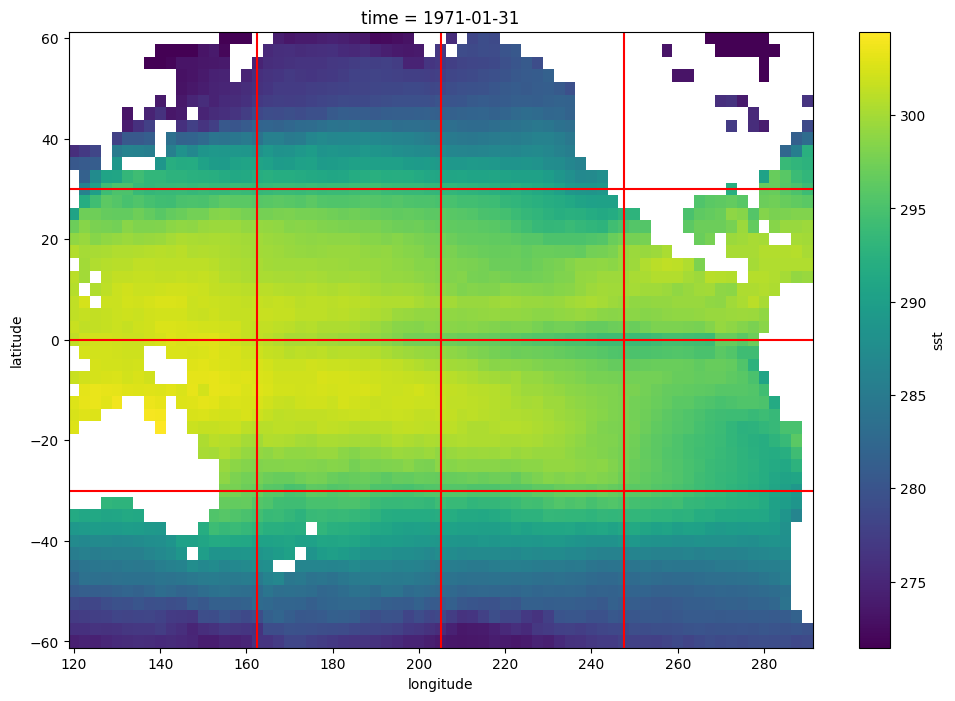

In [6]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

fig, axs = plt.subplots(figsize=(12,8))
ds_6means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
axs.axvline(162.5, c="red")
axs.axvline(247.5, c="red")
plt.show()

In [7]:
if generate_pcas:
    variables = ["SST", "SP", "TTR", "U10", "V10", "Z"]
    var_combi = []

    for r in range(1, len(variables) + 1):
        var_combi.extend(combinations(variables, r))

    # Iterate over each box and each combination of variables
    k = 0
    pcas = {}
    for box_id, box_coords in boxes2.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_6means, 3, [1972,2022], box_limit=box_coords, variables=var_combination)

            k +=1

    for box_id, box_coords in boxes1.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_6means, 3, [1972,2022], box_limit=box_coords, variables=var_combination)

            k +=1
    with open("pcas_1972.pkl", "wb") as inp:
        pickle.dump(pcas, inp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("pcas_1972.pkl", 'rb') as inp:
        pcas = pickle.load(inp)

In [13]:
print(f"Total of different PCAS {len(pcas)}")

Total of different PCAS 1512


In [8]:
hwis_chile= pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m')
hwis_chile.set_index('Date', inplace=True)
hwis_chile = hwis_chile.rolling(2).mean()

In [9]:
first_year = 1972
hwis_chile = hwis_chile[(hwis_chile.index.year <= 2022) & (hwis_chile.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_10572\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_10572\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_10572\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [10]:
corr_chile = hwis_chile.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_chile.describe()

,HWN,HWF,HWD,HWM,HWA
count,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000
mean,0.010770,0.008623,0.009584,0.004565,0.006235
std,0.069122,0.068983,0.069178,0.064036,0.066114
min,-0.286522,-0.269130,-0.271669,-0.262163,-0.277112
25%,-0.032219,-0.031264,-0.030776,-0.028114,-0.028431
50%,0.016326,0.008879,0.012506,-0.000477,0.003845
75%,0.047421,0.045254,0.044589,0.037395,0.038968
max,0.347974,0.323344,0.308664,0.298208,0.316201


In [11]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

season_correlations_chile = {}
seasons_any_corr_chile = {}

for i in range(12):
    hwis_month = hwis_chile[hwis_chile.index.month == i+1]
    correlations = {
    "pearson": compute_correlations(hwis_month),
    "spearman": compute_correlations(hwis_month, method='spearman')
    }

    # Initialize dictionaries to hold positive and negative correlations
    strong_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }
    any_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }

    # Iterate over each correlation matrix and collect pairs
    for method, corr_df in correlations.items():
        for timeserie, row in corr_df.iterrows():
            for index, value in row.items():
                if value > 0.5:
                    strong_correlations["positive"][method].append((timeserie, index, value))
                elif value < -0.5:
                    strong_correlations["negative"][method].append((timeserie, index, value))
                if value > 0:
                    any_correlations["positive"][method].append((timeserie, index, value))
                elif value < 0:
                    any_correlations["negative"][method].append((timeserie, index, value))

    # Convert to DataFrames for easy viewing and saving
    positive_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["positive"].items()
    }
    negative_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["negative"].items()
    }
    positive_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["positive"].items()
    }
    negative_corr_any_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in any_correlations["negative"].items()
    }
    season_correlations_chile[i+1] = [positive_corr_df, negative_corr_df]
    seasons_any_corr_chile[i+1] = [positive_corr_any_df, negative_corr_any_df]
    print("Ready season", i+1)



Ready season 1
Ready season 2
Ready season 3
Ready season 4
Ready season 5
Ready season 6
Ready season 7
Ready season 8
Ready season 9
Ready season 10
Ready season 11
Ready season 12


In [12]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in season_correlations_chile.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_chile = pd.DataFrame(
    all_correlations, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
all_correlations_df_chile['ID'] = all_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_chile['Variance'] = all_correlations_df_chile.apply(lambda x: pcas[int(x.ID)].explained_variance[str(x.Season)][int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_chile.reindex(
    all_correlations_df_chile["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

     Season    Method              PC Index  Correlation    ID  Variance
145       4   pearson   PC_918-Mode-2   HWA     0.623068   918  0.201196
172       4   pearson   PC_901-Mode-3   HWA     0.621789   901  0.138403
364       4  spearman   PC_918-Mode-2   HWA     0.621233   918  0.201196
390       4  spearman   PC_901-Mode-3   HWA     0.619709   901  0.138403
292       4   pearson   PC_936-Mode-3   HWA    -0.612834   936  0.166182
..      ...       ...             ...   ...          ...   ...       ...
327       4  spearman   PC_727-Mode-1   HWD     0.570712   727  0.314013
631       6   pearson  PC_1361-Mode-3   HWD     0.570485  1361  0.102878
162       4   pearson   PC_894-Mode-3   HWA     0.570399   894  0.106168
775       7   pearson  PC_1341-Mode-1   HWN     0.569876  1341  0.221275
199       4   pearson   PC_941-Mode-3   HWN     0.569826   941  0.139905

[100 rows x 7 columns]


In [27]:
# Initialize a list to collect all correlations from all months and methods
any_correlations_list = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in seasons_any_corr_chile.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                any_correlations_list.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
any_correlations_df_chile = pd.DataFrame(
    any_correlations_list, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
any_correlations_df_chile['ID'] = any_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))

any_correlations_df_chile['Variance'] = any_correlations_df_chile.apply(lambda x: pcas[int(x.ID)].explained_variance[str(x.Season)][int(x.PC[-1])-1], axis=1)


In [15]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
season_top1 = int(list(top_correlations["Season"])[0])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1} for season {season_top1}")

Highest correlation is PC_918 is on Box [205, 247.5, -60, -30] with variables ['SP', 'V10', 'Z'] on mode 2 for season 4


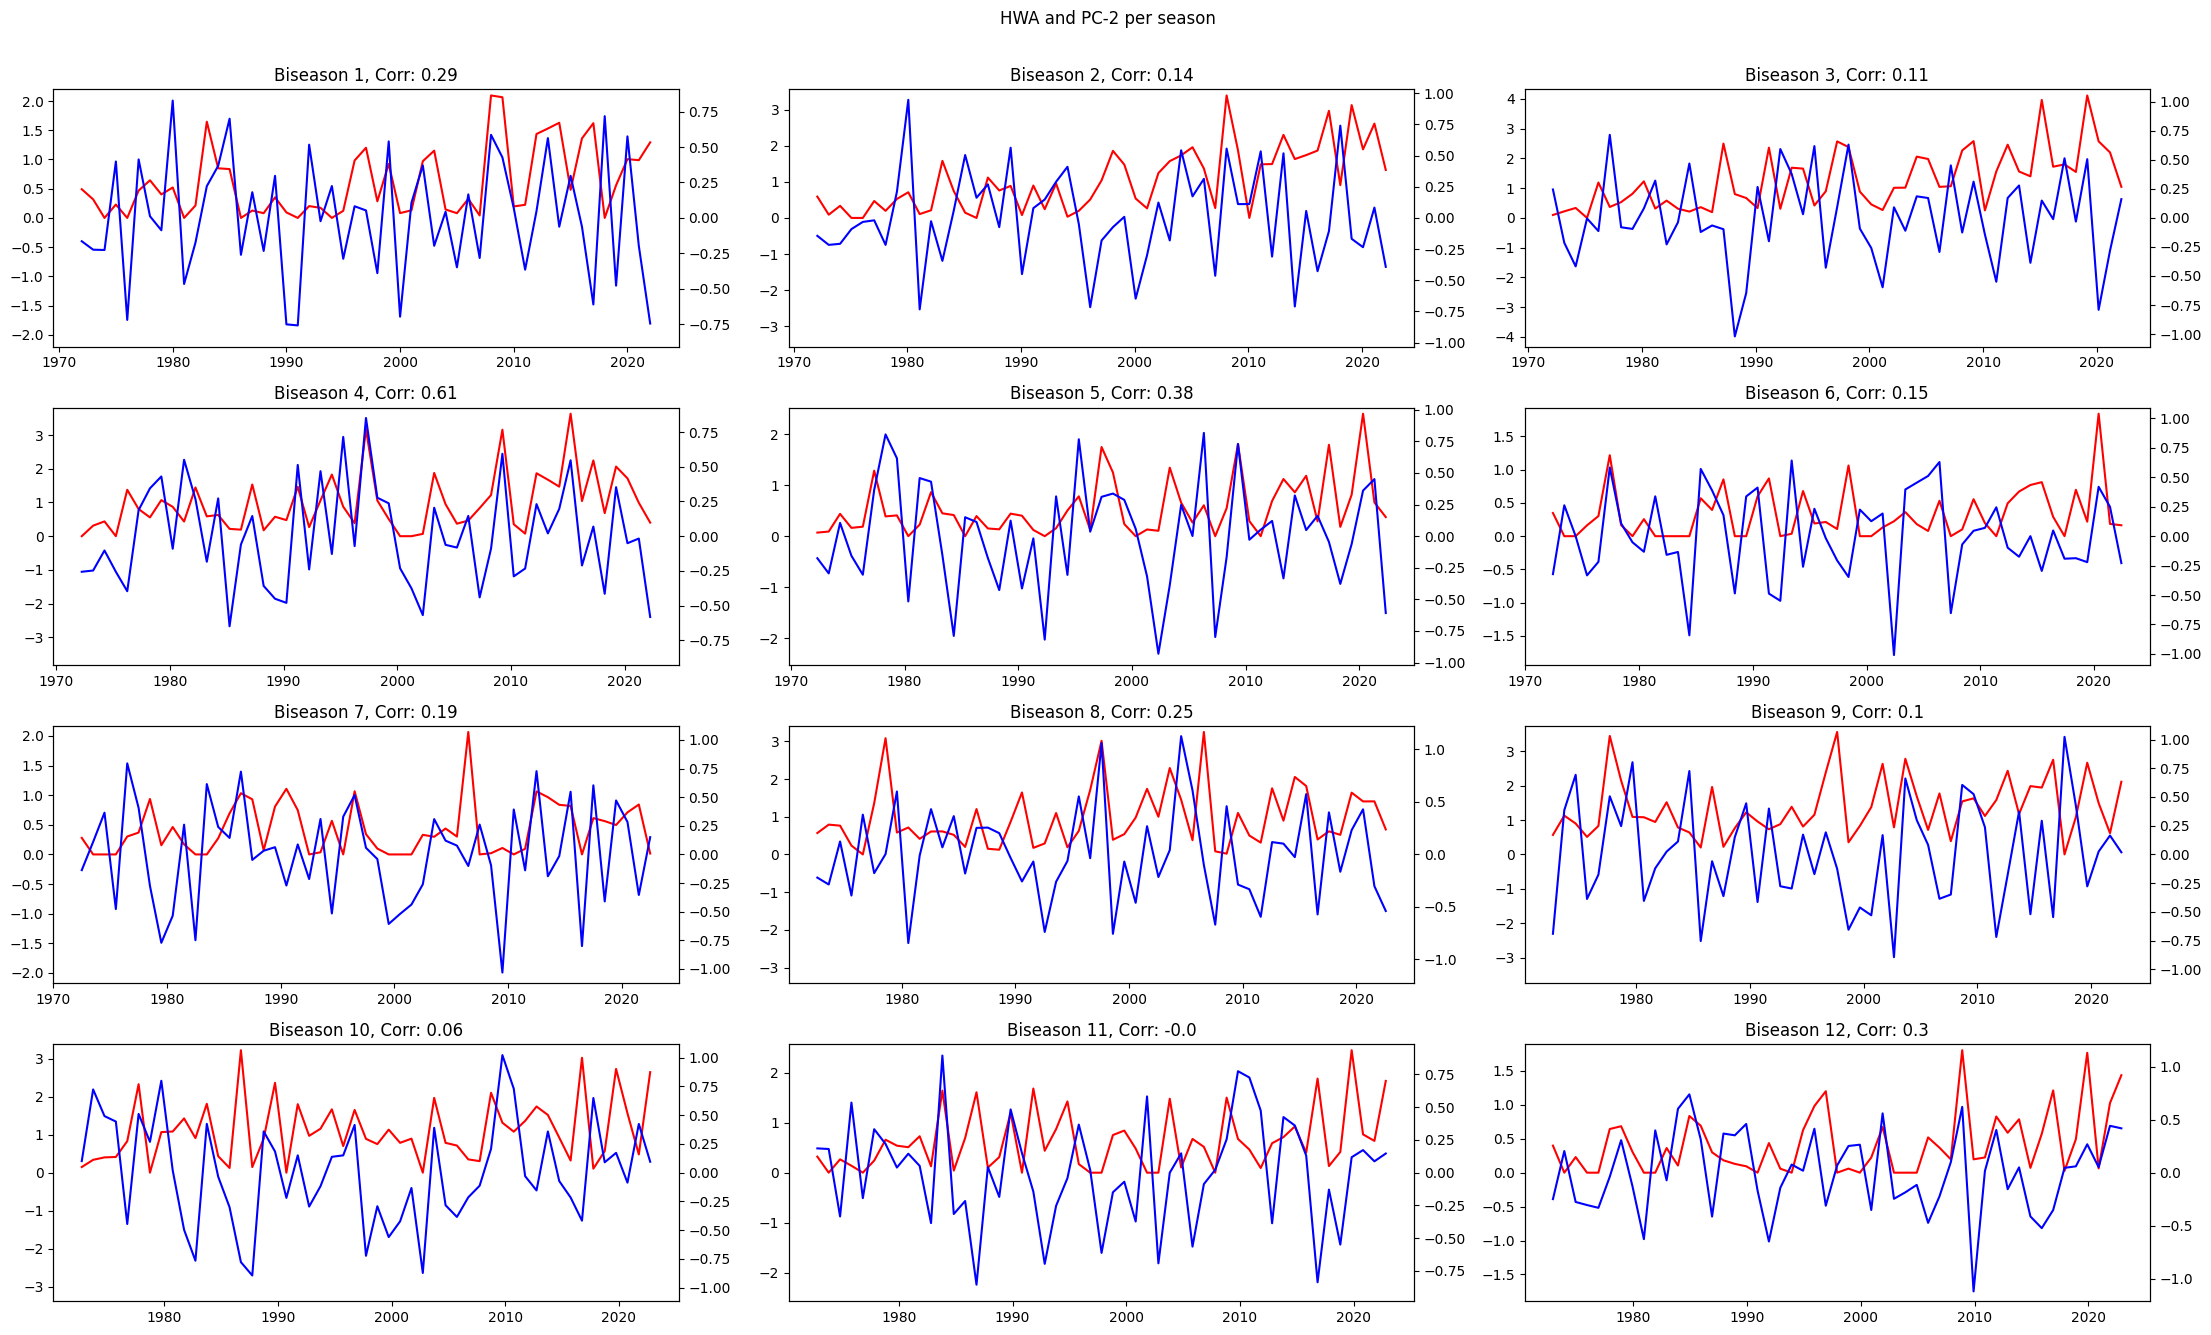

In [16]:
plot_hw_index_by_season(hwis_chile, "HWA", pcas[top1], mode_top1, start=first_year)

## Select Highest 10 for prediction

In [23]:
top_corr_per_season_chile = {}
id_per_season_chile = {}
for i in range(1,13):
    month_corr = any_correlations_df_chile[any_correlations_df_chile["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Correlation"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_chile[i] = []
    id_per_season_chile[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_chile[i]) == 10:
            break
        elif pc not in top_corr_per_season_chile[i]:
            top_corr_per_season_chile[i].append(pc)

print({i:len(top_corr_per_season_chile[i]) for i in range(1,13)})

{1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


In [24]:
save= False
if save:
    for i in range(1,13):
        hws_season = hwis_chile[hwis_chile.index.month == i][indices_of_interest + top_corr_per_season_chile[i]]
        hws_season.to_csv(f"HWs_chile_features_biseason_{i}.csv")

In [25]:
save_year= False
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_chile[i]
    
    hws_year = hwis_chile[indices_of_interest + pcs]
    hws_year.to_csv("HWs_chile_features_biseasonly_year.csv")

### Select best but removing low variance explaining ones.

In [28]:
top_corr_per_season_chile = {}
id_per_season_chile = {}

filtered_df_chile = any_correlations_df_chile[any_correlations_df_chile["Variance"] >= 0.10]
for i in range(1,13):
    month_corr = filtered_df_chile[filtered_df_chile["Season"]==i]
    top_corr = month_corr.reindex(
    month_corr["Correlation"].abs().sort_values(ascending=False).index
    )
    top_corr_per_season_chile[i] = []
    id_per_season_chile[i] = []
    k = 0
    for pc in list(top_corr["PC"]):
        if len(top_corr_per_season_chile[i]) == 10:
            break
        elif pc not in top_corr_per_season_chile[i]:
            top_corr_per_season_chile[i].append(pc)

print("Features per month", {i:len(top_corr_per_season_chile[i]) for i in range(1,13)})

save_season= False
if save_season:
    for i in range(1,13):
        hws_season = hwis_chile[hwis_chile.index.month == i][indices_of_interest + top_corr_per_season_chile[i]]
        hws_season.to_csv(f"HWs_chile_features_biseason_removing_{i}.csv")
save_year= False
if save_year:
    pcs = []
    for i in range(1,13):
        pcs = pcs + top_corr_per_season_chile[i]
    
    hws_year = hwis_chile[indices_of_interest + pcs]
    hws_year.to_csv("HWs_chile_features_biseasonly_removing_year.csv")

Features per month {1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
